In [1]:
import os, sys
from pathlib import Path

# 현재 워킹 디렉토리 기준으로 상위 2단계 경로 추가
src_path = Path(os.getcwd()).resolve().parents[1]  # /src
sys.path.append(str(src_path))

print(sys.path[-1])  # 확인용

/Users/seobi/PythonProjects/RAG_Commander/src


In [2]:
import os
print(os.getcwd())

/Users/seobi/PythonProjects/RAG_Commander/src/agents/main


In [ ]:
# %%writefile main_agent.py
from langchain_openai import ChatOpenAI
from langgraph.graph.state import Command, Literal
from main_state import StartConfirmation
from utils.enum import ModelName
from utils.util import get_today_str
from agents.main.main_state import MainState, StartInput
from langchain_core.messages import HumanMessage, get_buffer_string, AIMessage
from langgraph.graph import StateGraph, START, END
from prompts import PromptManager, PromptType

llm = ChatOpenAI(model=ModelName.GPT_4_1_MINI, temperature=0)
messages_key = MainState.Key.messages
start_input_key = MainState.Key.start_input


def start_confirmation(
    state: MainState,
) -> Command[Literal["start", "__end__"]]:

    parser_llm = llm.with_structured_output(StartConfirmation)
    messages_str = get_buffer_string(messages=state[messages_key])

    prompt = PromptManager(PromptType.MAIN_START_CONFIRMATION).get_prompt(
        messages=messages_str
    )
    response: StartConfirmation = parser_llm.invoke([HumanMessage(content=prompt)])

    if response.confirm == False:
        return Command(
            goto=END, update={messages_key: [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="start",
            update={messages_key: [AIMessage(content=response.verification)]},
        )


def start(state: MainState) -> MainState:
    parser_model = llm.with_structured_output(StartInput)
    prompt = PromptManager(PromptType.MAIN_START).get_prompt(
        messages=get_buffer_string(state[messages_key]), 
                                   date=get_today_str()
    )
    response: StartInput = parser_model.invoke([HumanMessage(content=prompt)])

    return {start_input_key: response.model_dump()}

graph_builder = StateGraph(MainState)
graph_builder.add_node("start_confirmation", start_confirmation)
graph_builder.add_node("start",start)

graph_builder.add_edge(START, "start_confirmation")
graph_builder.add_edge("start", END)



Overwriting main_agent.py


/Users/seobi/PythonProjects/RAG_Commander/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


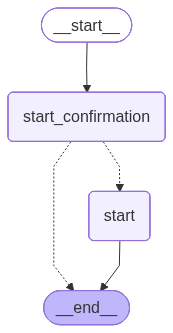

In [4]:
from main_agent import graph_builder
graph = graph_builder.compile()
graph

In [5]:
from utils.format_message import format_message
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from main_state import MainState
messages_key = MainState.Key.messages
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer = checkpointer)

thread = {"configurable": {"thread_id":"1"}}
result = graph.invoke(
    {
        messages_key : [HumanMessage(content = "경기도 분당구 정자동을 분석하고 싶습니다.")]
    },
    config = thread
)

format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "규모와 세대수는 당신이 아무렇게나 정해주세요")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "당신이 알아서 하나 정해주세요.")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [8]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "당신이 알아서 아파트도 아무거나 정해주세요.")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 아파트도 아무거나 정해주세요.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "한솔마을")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 아파트도 아무거나 정해주세요.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔마을                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 한솔마을이 정확히 어떤 아파트 단지를 의미하는지, 그리고 규모(부지 면적)와 세대수 정보를 알려주시겠습니까?       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "1000세대 ")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 아파트도 아무거나 정해주세요.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔마을                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 한솔마을이 정확히 어떤 아파트 단지를 의미하는지, 그리고 규모(부지 면적)와 세대수 정보를 알려주시겠습니까?       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 1000세대                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔마을'이 정확히 어떤 아파트 단지를 의미하는지 명확히 해주시고, 부지 면적(규모) 정보를 알려주시겠습니까?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "한솔 주공 5단지")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 아파트도 아무거나 정해주세요.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔마을                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 한솔마을이 정확히 어떤 아파트 단지를 의미하는지, 그리고 규모(부지 면적)와 세대수 정보를 알려주시겠습니까?       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 1000세대                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔마을'이 정확히 어떤 아파트 단지를 의미하는지 명확히 해주시고, 부지 면적(규모) 정보를 알려주시겠습니까?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔 주공 5단지                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 부지 면적(규모) 정보를 알려주시겠습니까?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "10000")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 아파트도 아무거나 정해주세요.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔마을                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 한솔마을이 정확히 어떤 아파트 단지를 의미하는지, 그리고 규모(부지 면적)와 세대수 정보를 알려주시겠습니까?       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 1000세대                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔마을'이 정확히 어떤 아파트 단지를 의미하는지 명확히 해주시고, 부지 면적(규모) 정보를 알려주시겠습니까?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔 주공 5단지                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 부지 면적(규모) 정보를 알려주시겠습니까?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 10000                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 부지 면적 단위가 무엇인지 명확히 알려주시겠습니까? 예를 들어, 제곱미터, 평 등 구체적인      │
│ 단위를 알려주세요.                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "제곱미터")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 아파트도 아무거나 정해주세요.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔마을                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 한솔마을이 정확히 어떤 아파트 단지를 의미하는지, 그리고 규모(부지 면적)와 세대수 정보를 알려주시겠습니까?       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 1000세대                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔마을'이 정확히 어떤 아파트 단지를 의미하는지 명확히 해주시고, 부지 면적(규모) 정보를 알려주시겠습니까?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔 주공 5단지                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 부지 면적(규모) 정보를 알려주시겠습니까?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 10000                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 부지 면적 단위가 무엇인지 명확히 알려주시겠습니까? 예를 들어, 제곱미터, 평 등 구체적인      │
│ 단위를 알려주세요.                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 제곱미터                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 정확한 위치(예: 도로명 주소 또는 상세 위치)를 알려주시겠습니까?                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
result = graph.invoke({
    messages_key: [HumanMessage(content = "경기도 성남시 분당구 정자동 112-1")]    
}, config = thread)
format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동을 분석하고 싶습니다.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동에 대해 보고서를 작성하려면 다음 정보를 알려주세요:                                         │
│ 1. 분석할 대상의 위치(예: 특정 아파트 단지명 등)                                                                │
│ 2. 규모(예: 부지 면적 등)                                                                                       │
│ 3. 세대수                                                                                                       │
│ 위 세 가지 중 하나라도 명확하지 않으면 보고서 작성이 어렵습니다. 해당 정보를 제공해 주시겠습니까?               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 규모와 세대수는 당신이 아무렇게나 정해주세요                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명이나 위치를 알려주시겠습니까?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 하나 정해주세요.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 당신이 알아서 아파트도 아무거나 정해주세요.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 분당구 정자동 내에서 분석할 특정 아파트 단지명을 알려주시겠습니까?                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔마을                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 한솔마을이 정확히 어떤 아파트 단지를 의미하는지, 그리고 규모(부지 면적)와 세대수 정보를 알려주시겠습니까?       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 1000세대                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔마을'이 정확히 어떤 아파트 단지를 의미하는지 명확히 해주시고, 부지 면적(규모) 정보를 알려주시겠습니까?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 한솔 주공 5단지                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 부지 면적(규모) 정보를 알려주시겠습니까?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 10000                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 부지 면적 단위가 무엇인지 명확히 알려주시겠습니까? 예를 들어, 제곱미터, 평 등 구체적인      │
│ 단위를 알려주세요.                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 제곱미터                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ '한솔 주공 5단지'의 정확한 위치(예: 도로명 주소 또는 상세 위치)를 알려주시겠습니까?                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 성남시 분당구 정자동 112-1                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 보고서 작성을 시작하겠습니다. 사용자가 제공한 정보에 따르면, 분석 대상은 경기도 성남시 분당구 정자동 112-1에    │
│ 위치한 '한솔 주공 5단지' 아파트이며, 부지 면적은 10,000 제곱미터, 세대수는 1,000세대입니다. 이 정보를 바탕으로  │
│ 전문적인 부동산 대행사 사내용 보고서를 작성하겠습니다.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯